# Price Predictor Linear Regression Model

In [29]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import timedelta
from sqlalchemy import create_engine
import psycopg2
from config import db_password

## Load in data

In [30]:
# database address
host_name = 'database-1.cvhixt1fojqo.us-east-1.rds.amazonaws.com'

In [31]:
# create the database engine
db_string = f"postgresql://postgres:{db_password}@{host_name}:5432/Crypto_Data"

In [32]:
engine = create_engine(db_string)

In [33]:
ada_df = pd.read_sql("SELECT * FROM ada_orig", con=engine)

In [34]:
ada_df.shape

(1668, 9)

In [35]:
ada_df.dtypes

type_crypto       object
date_orig         object
daystarttoend      int64
open_ada         float64
high_ada         float64
low_ada          float64
close_ada        float64
volume_ada       float64
marketcap_ada    float64
dtype: object

In [36]:
ada_df.tail()

,type_crypto,date_orig,daystarttoend,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada
1663,ada,2022-04-22,1664,0.909063,0.923691,0.894321,0.907236,1.201371e+09,2.867515e+10
1664,ada,2022-04-23,1665,0.906163,0.910934,0.883990,0.888474,7.555170e+08,2.826530e+10
1665,ada,2022-04-24,1666,0.887093,0.897949,0.880130,0.885290,5.521224e+08,2.800958e+10
1666,ada,2022-04-25,1667,0.885730,0.899764,0.830142,0.898860,1.175064e+09,2.721793e+10
1667,ada,2022-04-26,1668,0.897602,0.900668,0.819120,0.824140,1.311330e+09,2.730421e+10


## Transform datatypes

In [37]:
ada_df['date_orig'] = pd.to_datetime(ada_df["date_orig"])
ada_df.dtypes

type_crypto              object
date_orig        datetime64[ns]
daystarttoend             int64
open_ada                float64
high_ada                float64
low_ada                 float64
close_ada               float64
volume_ada              float64
marketcap_ada           float64
dtype: object

## Visualize Data

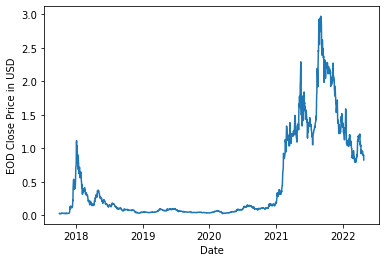

In [38]:
plt.plot(ada_df.date_orig, ada_df.close_ada)
plt.xlabel('Date')
plt.ylabel('EOD Close Price in USD')
plt.show()

## Adding in target variable

The target variable in this case will be the close price after one year for each piece of data

In [39]:
# intialize time delta for prediction
dt_days = 60

In [40]:
# initialize dt column for how far we want to predict
ada_df['date_pred'] = ada_df['date_orig'] + timedelta(days=dt_days)
ada_df.tail()

,type_crypto,date_orig,daystarttoend,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,date_pred
1663,ada,2022-04-22,1664,0.909063,0.923691,0.894321,0.907236,1.201371e+09,2.867515e+10,2022-06-21
1664,ada,2022-04-23,1665,0.906163,0.910934,0.883990,0.888474,7.555170e+08,2.826530e+10,2022-06-22
1665,ada,2022-04-24,1666,0.887093,0.897949,0.880130,0.885290,5.521224e+08,2.800958e+10,2022-06-23
1666,ada,2022-04-25,1667,0.885730,0.899764,0.830142,0.898860,1.175064e+09,2.721793e+10,2022-06-24
1667,ada,2022-04-26,1668,0.897602,0.900668,0.819120,0.824140,1.311330e+09,2.730421e+10,2022-06-25


In [41]:
# create a copy dataframe to pull target close price
ada_df_copy = ada_df.copy()
ada_df_copy.head()

,type_crypto,date_orig,daystarttoend,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,date_pred
0,ada,2017-10-02,1,0.024969,0.030088,0.019969,0.025808,8.310030e+07,567275650.8,2017-12-01
1,ada,2017-10-03,2,0.025671,0.027172,0.020575,0.020827,2.971484e+07,678634914.2,2017-12-02
2,ada,2017-10-04,3,0.020828,0.022962,0.020828,0.021973,1.243013e+07,569544386.4,2017-12-03
3,ada,2017-10-05,4,0.022035,0.022245,0.020839,0.021512,7.055960e+06,554868595.8,2017-12-04
4,ada,2017-10-06,5,0.021286,0.021576,0.018071,0.018481,6.207887e+06,521924570.1,2017-12-05


In [42]:
# merge dataframes to get target variable
#JOIN TABLES
ada_df_clean = ada_df.merge(ada_df_copy, how='left', left_on='date_pred', right_on='date_orig', suffixes=(None, '_pred'))
ada_df_clean.head()

,type_crypto,date_orig,daystarttoend,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,date_pred,type_crypto_pred,date_orig_pred,daystarttoend_pred,open_ada_pred,high_ada_pred,low_ada_pred,close_ada_pred,volume_ada_pred,marketcap_ada_pred,date_pred_pred
0,ada,2017-10-02,1,0.024969,0.030088,0.019969,0.025808,8.310030e+07,567275650.8,2017-12-01,ada,2017-12-01,61.0,0.121991,0.131560,0.115665,0.130919,1.132643e+08,3.060934e+09,2018-01-30
1,ada,2017-10-03,2,0.025671,0.027172,0.020575,0.020827,2.971484e+07,678634914.2,2017-12-02,ada,2017-12-02,62.0,0.131494,0.141014,0.130731,0.133987,6.671962e+07,3.524595e+09,2018-01-31
2,ada,2017-10-04,3,0.020828,0.022962,0.020828,0.021973,1.243013e+07,569544386.4,2017-12-03,ada,2017-12-03,63.0,0.133554,0.138828,0.127905,0.132972,4.924929e+07,3.413476e+09,2018-02-01
3,ada,2017-10-05,4,0.022035,0.022245,0.020839,0.021512,7.055960e+06,554868595.8,2017-12-04,ada,2017-12-04,64.0,0.133233,0.142153,0.128249,0.135653,5.986191e+07,3.413835e+09,2018-02-02
4,ada,2017-10-06,5,0.021286,0.021576,0.018071,0.018481,6.207887e+06,521924570.1,2017-12-05,ada,2017-12-05,65.0,0.135825,0.136222,0.128382,0.129202,5.861102e+07,3.420465e+09,2018-02-03


In [43]:
# drop empty rows
ada_df_pre_final = ada_df_clean.dropna()

In [69]:
# FOR POSTGRES "crypto_clean" table
crypto_clean_df = ada_df_pre_final[['type_crypto','date_orig','daystarttoend','open_ada','high_ada','low_ada','close_ada','volume_ada','marketcap_ada','date_pred','close_ada_pred']]
crypto_clean_df.columns

Index(['type_crypto', 'date_orig', 'daystarttoend', 'open_ada', 'high_ada',
       'low_ada', 'close_ada', 'volume_ada', 'marketcap_ada', 'date_pred',
       'close_ada_pred'],
      dtype='object')

In [70]:
crypto_clean_df.head()

,type_crypto,date_orig,daystarttoend,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,date_pred,close_ada_pred
0,ada,2017-10-02,1,0.024969,0.030088,0.019969,0.025808,8.310030e+07,567275650.8,2017-12-01,0.130919
1,ada,2017-10-03,2,0.025671,0.027172,0.020575,0.020827,2.971484e+07,678634914.2,2017-12-02,0.133987
2,ada,2017-10-04,3,0.020828,0.022962,0.020828,0.021973,1.243013e+07,569544386.4,2017-12-03,0.132972
3,ada,2017-10-05,4,0.022035,0.022245,0.020839,0.021512,7.055960e+06,554868595.8,2017-12-04,0.135653
4,ada,2017-10-06,5,0.021286,0.021576,0.018071,0.018481,6.207887e+06,521924570.1,2017-12-05,0.129202


In [44]:
# only include relevant features (X) and target variables (y)
ada_df_final = ada_df_pre_final[['open_ada','high_ada','low_ada','close_ada','volume_ada','marketcap_ada','close_ada_pred']]
ada_df_final.head()

,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,close_ada_pred
0,0.024969,0.030088,0.019969,0.025808,8.310030e+07,567275650.8,0.130919
1,0.025671,0.027172,0.020575,0.020827,2.971484e+07,678634914.2,0.133987
2,0.020828,0.022962,0.020828,0.021973,1.243013e+07,569544386.4,0.132972
3,0.022035,0.022245,0.020839,0.021512,7.055960e+06,554868595.8,0.135653
4,0.021286,0.021576,0.018071,0.018481,6.207887e+06,521924570.1,0.129202


## Create features and target

In [45]:
# features
X = ada_df_final.drop('close_ada_pred', axis=1)
X = X.values.reshape(-1,6)
X

array([[2.49695000e-02, 3.00877000e-02, 1.99693000e-02, 2.58084020e-02,
        8.31003000e+07, 5.67275651e+08],
       [2.56711360e-02, 2.71715620e-02, 2.05754950e-02, 2.08268640e-02,
        2.97148435e+07, 6.78634914e+08],
       [2.08280050e-02, 2.29620980e-02, 2.08280050e-02, 2.19732450e-02,
        1.24301341e+07, 5.69544386e+08],
       ...,
       [8.88620643e-01, 9.51808498e-01, 8.68721622e-01, 8.68721622e-01,
        2.13338621e+09, 2.87138719e+10],
       [8.64602493e-01, 8.87785492e-01, 7.49973525e-01, 8.50607108e-01,
        3.28178256e+09, 2.54251118e+10],
       [8.53524186e-01, 9.06099917e-01, 8.26432918e-01, 9.00405150e-01,
        3.02415751e+09, 2.71609820e+10]])

In [46]:
# target
y = ada_df_final['close_ada_pred']
y

0       0.130919
1       0.133987
2       0.132972
3       0.135653
4       0.129202
          ...   
1603    0.907236
1604    0.888474
1605    0.885290
1606    0.898860
1607    0.824140
Name: close_ada_pred, Length: 1608, dtype: float64

## Linear Regression Model

In [47]:
# initialize class for linear reg algorithms
model = LinearRegression()

In [48]:
# fit or train the data
model.fit(X,y)

LinearRegression()

In [49]:
# predict outcomes before current date
y_pred = model.predict(X)
print(y_pred.shape)

(1608,)


In [50]:
# slope
print(model.coef_)
# y-int
print(model.intercept_)

[-6.80473888e-02 -2.32821652e+00 -7.62679506e-01  7.94987429e-01
  5.17520748e-11  9.95230565e-11]
0.15577118337271662


## Visualize Outcome

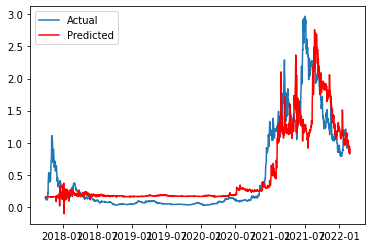

In [51]:
# display y_predictions based on the lin reg
plt.plot(ada_df_pre_final.date_orig, y)
plt.plot(ada_df_pre_final.date_orig, y_pred, color='red')
plt.legend(["Actual", "Predicted"])
plt.show()

## Test Data (predicting the future)

In [52]:
ada_df_clean.tail()

,type_crypto,date_orig,daystarttoend,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,date_pred,type_crypto_pred,date_orig_pred,daystarttoend_pred,open_ada_pred,high_ada_pred,low_ada_pred,close_ada_pred,volume_ada_pred,marketcap_ada_pred,date_pred_pred
1663,ada,2022-04-22,1664,0.909063,0.923691,0.894321,0.907236,1.201371e+09,2.867515e+10,2022-06-21,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1664,ada,2022-04-23,1665,0.906163,0.910934,0.883990,0.888474,7.555170e+08,2.826530e+10,2022-06-22,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1665,ada,2022-04-24,1666,0.887093,0.897949,0.880130,0.885290,5.521224e+08,2.800958e+10,2022-06-23,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1666,ada,2022-04-25,1667,0.885730,0.899764,0.830142,0.898860,1.175064e+09,2.721793e+10,2022-06-24,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1667,ada,2022-04-26,1668,0.897602,0.900668,0.819120,0.824140,1.311330e+09,2.730421e+10,2022-06-25,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [56]:
ada_df_test = ada_df_clean.loc[pd.isna(ada_df_clean["type_crypto_pred"]),:]
ada_df_test.head()

,type_crypto,date_orig,daystarttoend,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,date_pred,type_crypto_pred,date_orig_pred,daystarttoend_pred,open_ada_pred,high_ada_pred,low_ada_pred,close_ada_pred,volume_ada_pred,marketcap_ada_pred,date_pred_pred
1608,ada,2022-02-26,1609,0.898350,0.926141,0.884040,0.885834,1.719426e+09,2.839316e+10,2022-04-27,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1609,ada,2022-02-27,1610,0.886771,0.912703,0.836787,0.859935,1.213593e+09,2.756680e+10,2022-04-28,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1610,ada,2022-02-28,1611,0.858409,0.968166,0.844195,0.958826,1.837763e+09,2.824191e+10,2022-04-29,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1611,ada,2022-03-01,1612,0.963246,1.001739,0.948856,0.962327,2.146936e+09,3.040699e+10,2022-04-30,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1612,ada,2022-03-02,1613,0.962602,0.972596,0.928934,0.939092,1.656774e+09,2.995109e+10,2022-05-01,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [57]:
X_test = ada_df_test[['open_ada','high_ada','low_ada','close_ada','volume_ada','marketcap_ada']]
X_test = X_test.values.reshape(-1,6)
X_test

array([[8.98350131e-01, 9.26140571e-01, 8.84040101e-01, 8.85834224e-01,
        1.71942632e+09, 2.83931591e+10],
       [8.86771041e-01, 9.12702821e-01, 8.36787156e-01, 8.59935097e-01,
        1.21359323e+09, 2.75667982e+10],
       [8.58409146e-01, 9.68165948e-01, 8.44195206e-01, 9.58826243e-01,
        1.83776270e+09, 2.82419062e+10],
       [9.63246215e-01, 1.00173867e+00, 9.48856412e-01, 9.62326852e-01,
        2.14693596e+09, 3.04069891e+10],
       [9.62602134e-01, 9.72596368e-01, 9.28933802e-01, 9.39091815e-01,
        1.65677373e+09, 2.99510934e+10],
       [9.39194365e-01, 9.44838439e-01, 8.87316181e-01, 9.02674054e-01,
        1.23972383e+09, 2.87971434e+10],
       [9.02692802e-01, 9.02692802e-01, 8.30400071e-01, 8.42669610e-01,
        1.31093383e+09, 2.73968007e+10],
       [8.43669328e-01, 8.79292141e-01, 8.24940500e-01, 8.65949946e-01,
        1.21278602e+09, 2.69276880e+10],
       [8.65356209e-01, 8.70313681e-01, 8.21533393e-01, 8.23556706e-01,
        8.86277218e+08, 

In [58]:
# predict outcomes before current date
y_pred_future = model.predict(X_test)
print(y_pred_future.shape)

(60,)


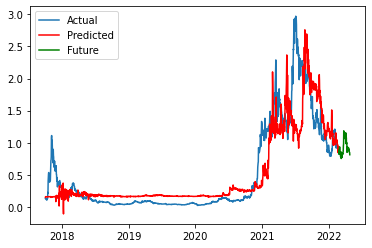

In [59]:
# display y_predictions based on the lin reg
plt.plot(ada_df_pre_final.date_orig, y)
plt.plot(ada_df_pre_final.date_orig, y_pred, color='red')
plt.plot(ada_df_test.date_orig, y_pred_future, color='green')
plt.legend(["Actual", "Predicted", 'Future'])
plt.show()

## Creating Output Dataframe

In [60]:
close_pred_series = pd.Series(y_pred).append(pd.Series(y_pred_future))
close_pred_df = pd.DataFrame(close_pred_series, columns=['close'])
close_pred_df.reset_index(inplace=True)
close_pred_df

,index,close
0,0,0.150066
1,1,0.160705
2,2,0.159803
3,3,0.159276
4,4,0.157265
...,...,...
1663,55,0.898532
1664,56,0.857530
1665,57,0.853497
1666,58,0.851728


In [65]:
crypto_60_day_df = pd.DataFrame(ada_df_clean['type_crypto'])
crypto_60_day_df['date_orig'] = ada_df_clean['date_orig']
crypto_60_day_df['close_orig'] = ada_df_clean['close_ada']
crypto_60_day_df['date_pred_60_day'] = ada_df_clean['date_pred']
crypto_60_day_df['close_pred_60_day'] = close_pred_df['close']
len(crypto_60_day_df)

1668

In [66]:
crypto_60_day_df

,type_crypto,date_orig,close_orig,date_pred_60_day,close_pred_60_day
0,ada,2017-10-02,0.025808,2017-12-01,0.150066
1,ada,2017-10-03,0.020827,2017-12-02,0.160705
2,ada,2017-10-04,0.021973,2017-12-03,0.159803
3,ada,2017-10-05,0.021512,2017-12-04,0.159276
4,ada,2017-10-06,0.018481,2017-12-05,0.157265
...,...,...,...,...,...
1663,ada,2022-04-22,0.907236,2022-06-21,0.898532
1664,ada,2022-04-23,0.888474,2022-06-22,0.857530
1665,ada,2022-04-24,0.885290,2022-06-23,0.853497
1666,ada,2022-04-25,0.898860,2022-06-24,0.851728
